In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Maze1:
    def __init__(self):
        self.maze = np.zeros((6, 9))
        obstacle = [(3, i) for i in range(8)]
        self.maze[*tuple(zip(*obstacle))] = 1

        self.start = (5, 3)
        self.goal = (0, 8)

    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        action_table = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        next_state = self.state + np.array(action_table[action])
        next_state = tuple(next_state)

        if next_state[0] < 0 or next_state[0] >= 6 or next_state[1] < 0 or next_state[1] >= 9:
            next_state = self.state

        if self.maze[next_state] == 1:
            next_state = self.state

        self.state = next_state
        reward = 0
        done = False

        if next_state == self.goal:
            reward = 1
            done = True

        return next_state, reward, done

In [3]:
class Maze2:
    def __init__(self):
        self.maze = np.zeros((6, 9))
        obstacle = [(3, i) for i in range(1, 9)]
        self.maze[*tuple(zip(*obstacle))] = 1

        self.start = (5, 3)
        self.goal = (0, 8)

    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        action_table = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        next_state = self.state + np.array(action_table[action])
        next_state = tuple(next_state)

        if next_state[0] < 0 or next_state[0] >= 6 or next_state[1] < 0 or next_state[1] >= 9:
            next_state = self.state

        if self.maze[next_state] == 1:
            next_state = self.state

        self.state = next_state
        reward = 0
        done = False

        if next_state == self.goal:
            reward = 1
            done = True

        return next_state, reward, done

In [4]:
class DynaQ:
    def __init__(self, n, maze_type, do=False):
        self.gamma = 0.95
        self.alpha = 0.3
        self.epsilon = 0.1

        self.n = n
        self.Q = np.zeros((6, 9, 4))

        self.maze_type = maze_type

        if maze_type == 1:
            self.env = Maze1()
            self.max_cum_steps = 4000
            self.change_maze_step = 1000
        
        elif maze_type == 2:
            self.env = Maze2()
            self.max_cum_steps = 6000
            self.change_maze_step = 3000

        if do:
            self.do()

    def change_maze(self):
        if self.maze_type == 1:
            self.env.maze[3, 0] = 0
            self.env.maze[3, 8] = 1
        elif self.maze_type == 2:
            self.env.maze[3, 8] = 0

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            max_index = np.where(self.Q[state] == np.max(self.Q[state]))[0]
            return np.random.choice(max_index)
        
    def update(self, state, action, reward, next_state, done):
        if done:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
    
    def do(self):

        model = []

        cum_rewards = 0
        cum_steps = 0
        self.log = []
        while cum_steps < self.max_cum_steps:
            state = self.env.reset()

            for _ in range(self.max_cum_steps):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                cum_rewards += reward
                cum_steps += 1

                m = (state, action, reward, next_state, done)
                for i in range(len(model)):
                    if state == model[i][0] and action == model[i][1]:
                        model[i] = m
                        break
                else:
                    model.append(m)

                self.update(state, action, reward, next_state, done)

                for _ in range(self.n):
                    idx = np.random.randint(len(model))
                    state_, action_, reward_, next_state_, done_ = model[idx]
                    self.update(state_, action_, reward_, next_state_, done_)
                    
                state = next_state

                self.log.append((cum_steps, cum_rewards))

                if cum_steps == self.change_maze_step:
                    self.change_maze()
                    
                if done or cum_steps >= self.max_cum_steps:
                    break

        self.log = np.array(self.log)

In [5]:
class DynaQPlus:
    def __init__(self, n, maze_type, do=False):
        self.gamma = 0.95
        self.alpha = 0.3
        self.epsilon = 0.1

        self.kappa = 0.001

        self.n = n
        self.Q = np.zeros((6, 9, 4))

        self.maze_type = maze_type

        if maze_type == 1:
            self.env = Maze1()
            self.max_cum_steps = 4000
            self.change_maze_step = 1000
        
        elif maze_type == 2:
            self.env = Maze2()
            self.max_cum_steps = 6000
            self.change_maze_step = 3000

        if do:
            self.do()

    def change_maze(self):
        if self.maze_type == 1:
            self.env.maze[3, 0] = 0
            self.env.maze[3, 8] = 1
        elif self.maze_type == 2:
            self.env.maze[3, 8] = 0

    def choose_action(self, state):      
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)  
        
        no_action = np.where(self.Q[state] == 0)[0]
        if len(no_action) != 0:
            return np.random.choice(no_action)
        else:
            max_index = np.where(self.Q[state] == np.max(self.Q[state]))[0]
            return np.random.choice(max_index)
        
    def update(self, state, action, reward, next_state, done, cum_steps):
        new_reward = reward + self.kappa * np.sqrt(cum_steps)

        if done:
            self.Q[state][action] += self.alpha * (new_reward - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (new_reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
    
    def do(self):

        model = []

        cum_rewards = 0
        cum_steps = 0
        self.log = []
        while cum_steps < self.max_cum_steps:
            state = self.env.reset()

            for _ in range(self.max_cum_steps):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                cum_rewards += reward
                cum_steps += 1

                m = (state, action, reward, next_state, done, cum_steps)
                for i in range(len(model)):
                    if state == model[i][0] and action == model[i][1]:
                        model[i] = m
                        break
                else:
                    model.append(m)

                self.update(state, action, reward, next_state, done, 0)

                for __ in range(self.n):
                    idx = np.random.randint(len(model))
                    state_, action_, reward_, next_state_, done_ , model_last_update = model[idx]
                    self.update(state_, action_, reward_, next_state_, done_, cum_steps - model_last_update)

                if cum_steps == self.change_maze_step:
                    self.change_maze()

                self.log.append((cum_steps, cum_rewards))
                state = next_state
                if done or cum_steps >= self.max_cum_steps:
                    break

        self.log = np.array(self.log)

In [6]:
class DynaQPLusMod:
    def __init__(self, n, maze_type, do=False):
        self.gamma = 0.95
        self.alpha = 0.3
        self.epsilon = 0.1

        self.kappa = 0.001

        self.n = n
        self.Q = np.zeros((6, 9, 4))
        self.last_update = np.zeros((6, 9, 4))

        self.maze_type = maze_type

        if maze_type == 1:
            self.env = Maze1()
            self.max_cum_steps = 4000
            self.change_maze_step = 1000
        
        elif maze_type == 2:
            self.env = Maze2()
            self.max_cum_steps = 6000
            self.change_maze_step = 3000

        if do:
            self.do()

    def change_maze(self):
        if self.maze_type == 1:
            self.env.maze[3, 0] = 0
            self.env.maze[3, 8] = 1
        elif self.maze_type == 2 or self.maze_type == 3:
            self.env.maze[3, 8] = 0

    def choose_action(self, state, cum_steps):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(4)
            self.last_update[state][action] = cum_steps
            return action
        else:
            new_Q = self.Q[state] + self.kappa * np.sqrt(cum_steps - self.last_update[state])
            max_index = np.where(new_Q == np.max(new_Q))[0]
            action = np.random.choice(max_index)
            self.last_update[state][action] = cum_steps
            return action
        
    def update(self, state, action, reward, next_state, done):
        if done:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
    
    def do(self):

        model = []

        cum_rewards = 0
        cum_steps = 0
        self.log = []
        while cum_steps < self.max_cum_steps:
            state = self.env.reset()

            for _ in range(self.max_cum_steps):
                action = self.choose_action(state, cum_steps)
                next_state, reward, done = self.env.step(action)
                cum_rewards += reward
                cum_steps += 1

                m = (state, action, reward, next_state, done)
                for i in range(len(model)):
                    if state == model[i][0] and action == model[i][1]:
                        model[i] = m
                        break
                else:
                    model.append(m)

                self.update(state, action, reward, next_state, done)

                for _ in range(self.n):
                    idx = np.random.randint(len(model))
                    state_, action_, reward_, next_state_, done_ = model[idx]
                    self.update(state_, action_, reward_, next_state_, done_)
                    
                state = next_state

                self.log.append((cum_steps, cum_rewards))

                if cum_steps == self.change_maze_step:
                    self.change_maze()
                    
                if done or cum_steps >= self.max_cum_steps:
                    break

        self.log = np.array(self.log)

In [7]:
dynaQ_30_1 = [DynaQ(50, 1, do=True) for _ in range(30)]
dynaQPlus_30_1 = [DynaQPlus(50, 1, do=True) for _ in range(30)]
dynaQPlusMod_30_1 = [DynaQPLusMod(50, 1, do=True) for _ in range(30)]

logs_30_1 = np.array([d.log for d in dynaQ_30_1])
logs_30_plus_1 = np.array([d.log for d in dynaQPlus_30_1])
logs_30_plus_mod_1 = np.array([d.log for d in dynaQPlusMod_30_1])

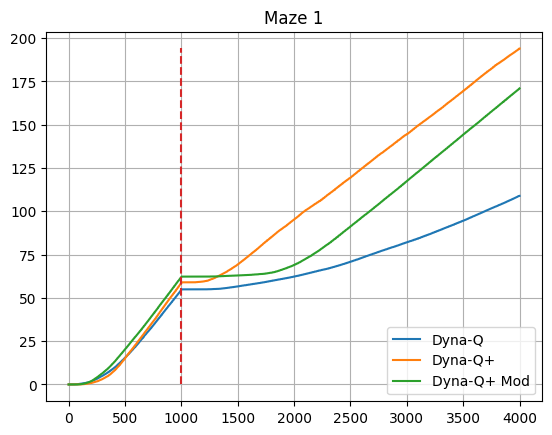

In [8]:
plt.plot(logs_30_1.mean(axis=0)[:,0], logs_30_1.mean(axis=0)[:,1], label='Dyna-Q')
plt.plot(logs_30_plus_1.mean(axis=0)[:,0], logs_30_plus_1.mean(axis=0)[:,1], label='Dyna-Q+')
plt.plot(logs_30_plus_mod_1.mean(axis=0)[:,0], logs_30_plus_mod_1.mean(axis=0)[:,1], label='Dyna-Q+ Mod')

plt.plot(np.zeros(2)+1000, [0, max(logs_30_plus_1.mean(axis=0)[:,1])], '--')
plt.title('Maze 1')
plt.legend()
plt.grid()
plt.show()

In [9]:
dynaQ_30_2 = [DynaQ(50, 2, do=True) for _ in range(30)]
dynaQPlus_30_2 = [DynaQPlus(50, 2, do=True) for _ in range(30)]
dynaQPlusMod_30_2 = [DynaQPLusMod(50, 2, do=True) for _ in range(30)]

logs_30_2 = np.array([d.log for d in dynaQ_30_2])
logs_30_plus_2 = np.array([d.log for d in dynaQPlus_30_2])
logs_30_plus_mod_2 = np.array([d.log for d in dynaQPlusMod_30_2])

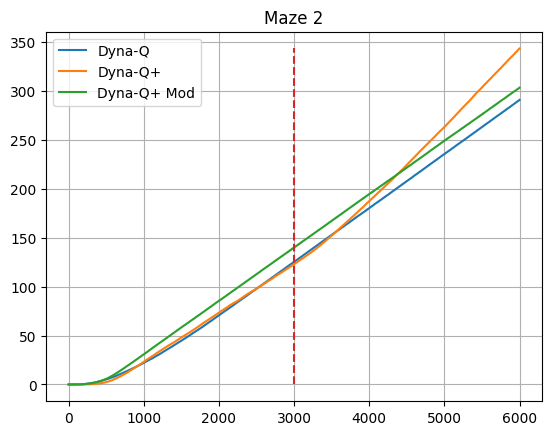

In [10]:
plt.plot(logs_30_2.mean(axis=0)[:,0], logs_30_2.mean(axis=0)[:,1], label='Dyna-Q')
plt.plot(logs_30_plus_2.mean(axis=0)[:,0], logs_30_plus_2.mean(axis=0)[:,1], label='Dyna-Q+')
plt.plot(logs_30_plus_mod_2.mean(axis=0)[:,0], logs_30_plus_mod_2.mean(axis=0)[:,1], label='Dyna-Q+ Mod')

plt.plot(np.zeros(2)+3000, [0, max(logs_30_plus_2.mean(axis=0)[:,1])], '--')
plt.title('Maze 2')
plt.legend()
plt.grid()
plt.show()